$$\require{mhchem}$$

# Adiabatic flame temperature notebook.

## Extension: detailed calculations, using interpolation of $h_k$ via JANAF tables.

Here, we will extend the initial JANAF table demonstration by interpolating the JANAF table species enthalpy values to locate the temperature where $h_{\rm mix, 2} = h_{\rm mix, 1}$.

To do this, we will use some slightly more advanced coding, where we import an interpolation function from an external library (the popular [SciPy](https://scipy.org/)) to create a lookup function for us.  We will also use the [NumPy](https://numpy.org/) library to handle matrix mathematics for us).  Lastly, we will import [Matplotlib](matplotlib.org) to handle some basic plotting.

### Import libaries.
Begin by importing the necessary external libraries and functions. The "import XX as YY" syntax gives us an alias for each libaray--basically a shortcut that lets us refer to the imported library or function, while avoiding confunsion between any imported function names and any functions that are already pre-defined in our namespace.

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

### Load the JANAF Tables:

We load the JANAF tables for the relevant species, which we have alreadyt downloaded from [janaf.nist.gov]().

We use the NumPy `loadtxt`function to read and load these data files as NumPy arrayts (basically, a matrix).  The first three rows of data correspond to headers, so the `skiprows` entry tells NumPy not to try and read those.

In [3]:
ch4_data = np.loadtxt('data/ch4_janaf.txt',dtype='float', skiprows=3)
o2_data = np.loadtxt('data/o2_janaf.txt',dtype='float', skiprows=3)
co2_data = np.loadtxt('data/co2_janaf.txt',dtype='float', skiprows=3)
h2o_data = np.loadtxt('data/h2o_janaf.txt',dtype='float', skiprows=3)
n2_data = np.loadtxt('data/n2_janaf.txt',dtype='float', skiprows=3)

### Create interpolation functions:

The JANAF tables give us molar enthalpies at discrete temperature values, which may or may not correspond to the adiabatic flame temperatrure of interest.  In order to interpolate between the JANAF table values, we crate here a linear interpolation function for each species, using the `interp1d` function that we imported above.

We need both the enthalpies of formation for each active species (i.e. not nitrogen) and the molar enthapy as a function of temperature for the product species ($\ce{CO2}$, $\ce{H2O}$, and $\ce{N2}$). The former values are in the 6th colum of each data file, and the latter values are stored in the fifth column.  The first column for each data file is the temperature, in K. 

Importantly, the species enthalpies stored in column five are _relative_ to that at the reference temperature of 298 K.  i.e. we do not need to subtract $h_k \left(298\,{\rm K}\right)$ in order to find $q_{\rm heating}$; that is already done for us!

For the unfamiliar, note that NumPy (and Python in general) starts counting all vector and matrix positions at 0. The variable `data[0]` therefore corresponds to the first item in the vector `data`, `data[1]` the second item, etc.

In [4]:
ch4_h_f = np.interp(298.15, ch4_data[:,0], ch4_data[:,5])
o2_h_f = np.interp(298.15, o2_data[:,0], o2_data[:,5])
co2_h_f = np.interp(298.15, co2_data[:,0], co2_data[:,5])
h2o_h_f = np.interp(298.15, h2o_data[:,0], h2o_data[:,5])

co2_dh = interp1d(co2_data[:,0], co2_data[:,4])
h2o_dh = interp1d(h2o_data[:,0], h2o_data[:,4])
n2_dh = interp1d(n2_data[:,0], n2_data[:,4])

These functions are now callable, as a function of temperature.  We can loop through a range of temperatures and create a more densely populated table of species enthalpies.  To demonstrate, let's plot the enthalpy of $\ce{CO2}$ as a function of temperature betwen 300 K and 6000 K, and shows that it accurately reproduces the JANAF data:

<IPython.core.display.Javascript object>


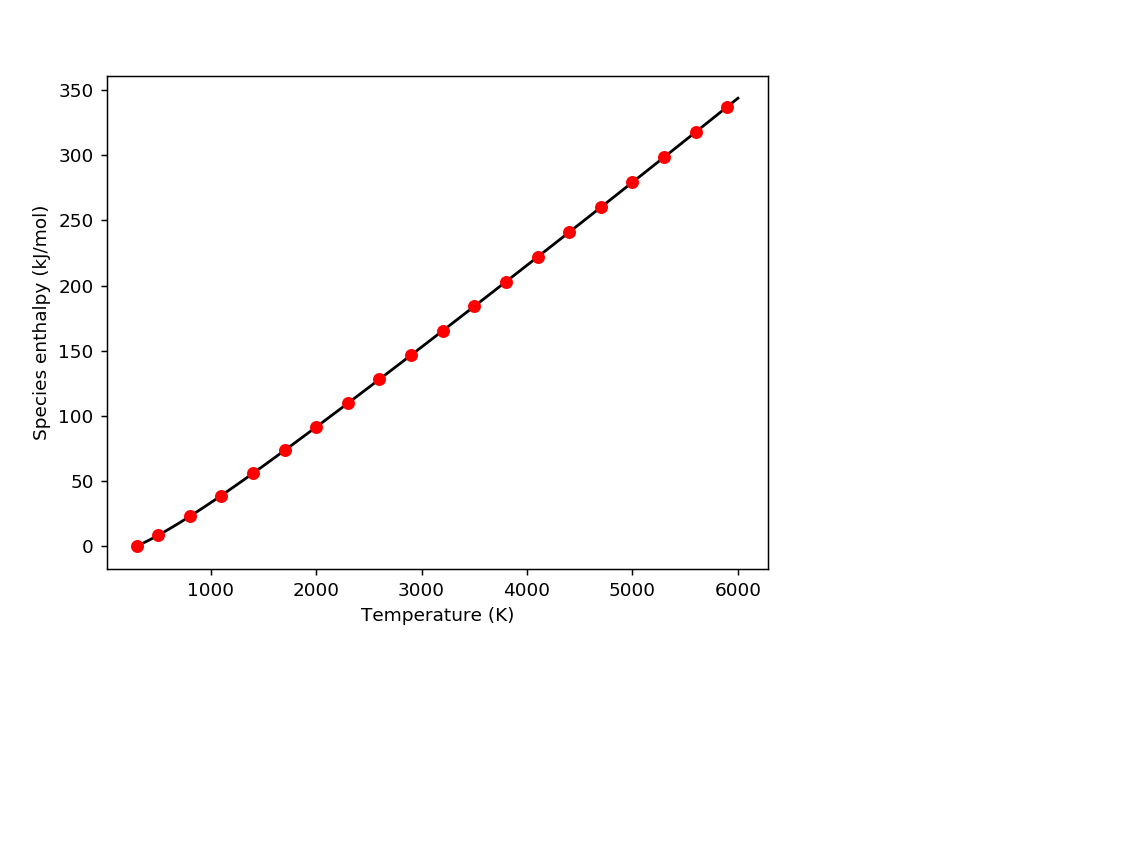

Text(0, 0.5, 'Species enthalpy (kJ/mol)')

In [7]:
%matplotlib notebook

temps = np.linspace(300,6000,100)
h_co2 = np.zeros_like(temps)

for j, T in enumerate(temps):
    h_co2[j] = co2_dh(T)
    
plt.plot(temps,h_co2,'k')
plt.plot(co2_data[2::3,0], co2_data[2::3,4],'ro')
plt.xlabel('Temperature (K)')
plt.ylabel('Species enthalpy (kJ/mol)')

As we can see, our interpolation function (the solid line) provides an accurate represntation of the tabulated data!

Now, let's calculate the heat released by the reaction:

In [10]:
q_rxn = ch4_h_f + 2*o2_h_f - 2*h2o_h_f - co2_h_f 

print(f"Heat of combustion = {q_rxn:.2f} kJ/mol.")

Heat of combustion = 802.30 kJ/mol.


This heat is stored as sensible heat of the products: i.e. it heats up the products to a higher temperature. We need to find the temperature at which the enthalpy of the products, relative to their enthalpy at the initial/reference temperature, equals the heat of the reaction.

We will loop over a range of temperatures and calculate this relative enthalpy, then interpolate between these values to find the temperature of interst.  Note that the first step is necessary because the JANAF tables do not include the exact same temperatures for each species.  If they did, we could simply operate on the tabulated data to find the relative enthalpy of the products as a function fo T and interpolate directly on that result.

In [15]:
q_heating = np.zeros_like(temps)

# The 'enumerate' function loops over the elements in 'temps', 
#   and also returns the index (as the local variable j) of each.
for j, T in enumerate(temps):
    q_heating[j] = 2*h2o_dh(T) + co2_dh(T) + 2*3.76*n2_dh(T)

# This 'interp' function call says "For the pair of arrays 
#   'q_heating' and 'temps', find me the value of 'temps' that 
#   corresponds to the location where 'q_heating' equals 'q_rxn'."
T_adiabatic = np.interp(q_rxn, q_heating, temps)

print(f"The adiabatic flame temperature is T_ad = {T_adiabatic:.2f} K.")


The adiabatic flame temperature is T_ad = 2327.16 K.
